# Tensor based approach to Spearman's pitch control

Code from anenglishgoat [https://github.com/anenglishgoat/Metrica-pitch-control/blob/master/FastSpearmanPitchControl.ipynb ] <br>

This approach uses a loop for integration just like Laurie Shaw did! <br>

In [1]:
import sys
sys.path.append('C:\\Users\\DavidB\\PycharmProjects\\My_Football_Analytics')

import pandas as pd
import numpy as np
import torch
from torch.nn.functional import softplus

import Basics.Data.Metrica_IO as mio
from Position_data.Tracking_Data import tracking_data
## set GPU or CPU (uncomment second line to use CPU)
# device = torch.device('cuda:0'); dtype = torch.float16
device = 'cpu'; dtype = torch.float32

In [2]:
away_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
home_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)

data_dir = 'sample-data-master/data/'
game_id = 1
away = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Away')
home = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Home')
td = mio.merge_tracking_data(home, away)
td_object = tracking_data(td, data_source='metrica', scale_to_pitch='myPitch')
td_object.get_velocities()

Reading team: away
Reading team: home


In [3]:
relu = torch.nn.ReLU()
jitter = 1e-12 ## prevents division by zero when player is stationary

## set nans to large negative value -- this makes pitch control for players who aren't involved negligibly small everywhere
# on the pitch
home_pos = np.array([np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([105,68])
np.nan_to_num(home_pos,copy=False,nan=-1000)
away_pos = np.array([np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([105,68])
np.nan_to_num(away_pos,copy=False,nan=-1000)
ball_pos = (np.asarray(home_data.iloc[:,range(31,33)]) * np.array([105,68]))[:,None,None,:]


# defining the delta in seconds between frames
tt = np.asarray(home_data['Time [s]'])
dt = tt[1:] - tt[:-1] 
# velocity in both x and y axis + jitter 
# jitter prevents division by zero when player is stationary
home_v = (home_pos[:,1:,:] - home_pos[:,:-1,:])/dt[:,None] + jitter
np.nan_to_num(home_v,copy=False,nan=-1000)
away_v = (away_pos[:,1:,:] - away_pos[:,:-1,:])/dt[:,None] + jitter
np.nan_to_num(away_v,copy=False,nan=-1000)
# velocity -1000 not really necessary?




# severe changes in the shape of the arrays
# I am not 100% how and why this is necessary
# This is probably necessary for later 
home_pos = home_pos[:,1:,None,None,:]
away_pos = away_pos[:,1:,None,None,:]
home_v = home_v[:,:,None,None,:]
away_v = away_v[:,:,None,None,:]
ball_pos = ball_pos[None,1:]

## set up evaluation grid and set some pitch control parameters (these are taken from the FoT code)
reaction_time = 0.7
max_player_speed = 5.
average_ball_speed = 15.
sigma = np.pi / np.sqrt(3.) / 0.45
lamb = 4.3
n_grid_points_x = 50
n_grid_points_y = 30
# create grid based on tensors
XX,YY = torch.meshgrid(torch.linspace(0,105,n_grid_points_x, device = device, dtype=dtype),
                       torch.linspace(0,68,n_grid_points_y,device=device,dtype=dtype))
target_position = torch.stack([XX,YY],2)[None,None,:,:,:] # all possible positions


# the weights and the x-points of the Gauss–Legendre quadrature are set up and stored as torch tensors
# I assume that, as the Gauss–Legendre quadrature spans the range of [-1, 1] (length of 2), the 50 points selected
# represent the number of frames in a 2 second time period based on a framerate of 25Hz (i.e. 25 frames / second)
ti,wi = np.polynomial.legendre.leggauss(50) ## used for numerical integration later on
ti = torch.tensor(ti,device = device,dtype=dtype)
wi = torch.tensor(wi,device=device,dtype=dtype)




n_frames = home_pos.shape[1]
first_frame = 0
batch_size = 250

# time to intercept empty torch
tti = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)
# 28 players*500 batches*grid
tmp2 = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y,1],device = device,dtype=dtype)
# 28 players*500 batches*grid * 1
pc = torch.empty([n_frames,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)
# frames * grid

In [4]:
#for f in range(int(n_frames/batch_size)):
for f in range(1):
    bp = torch.tensor(ball_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
    hp = torch.tensor(home_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
    hv = torch.tensor(home_v[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
    ap = torch.tensor(away_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
    av = torch.tensor(away_v[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))],device = device,dtype=dtype)
    ball_travel_time = torch.norm(target_position - bp, dim=4).div_(average_ball_speed)
    r_reaction_home = hp + hv.mul_(reaction_time)
    r_reaction_away = ap + av.mul_(reaction_time)
    r_reaction_home = r_reaction_home - target_position
    r_reaction_away = r_reaction_away - target_position
    tti[:14,:ball_travel_time.shape[1]] = torch.norm(r_reaction_home,dim=4).add_(reaction_time).div_(max_player_speed)
    tti[14:,:ball_travel_time.shape[1]] = torch.norm(r_reaction_away,dim=4).add_(reaction_time).div_(max_player_speed)

    y = torch.zeros([28,bp.shape[1],n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)

    for tt in range(500):
        sumy = torch.sum(y, dim=0) # control over all players
        if torch.min(sumy) > 0.99:
            break
        # added relu to tackle infinite negative due to infinite large sumy!
        y += 0.04 * lamb * relu(1. - sumy) * 1. / (1. + torch.exp(-sigma * (0.04*tt + ball_travel_time - tti)))
        #print(f'tt: {tt}: y: {y[:, 216, 15, 16]}, sumy: {sumy[216, 15, 16]}, tti: {tti[:, 216, 15, 16]}, btt: {ball_travel_time[0, 216, 15, 16]}')
        # dt * lambda * probability that noone else control it * probability of intercept as in eq (3)
        # for every dt after ball arrived until convergence  
    pc[(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))] = y[:14].sum(0)


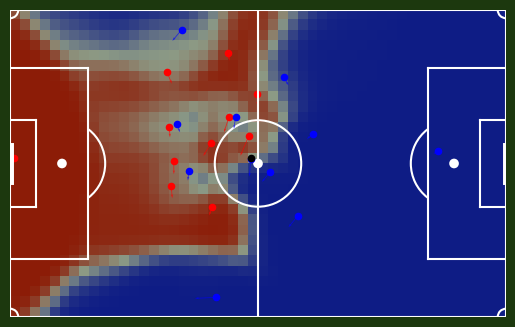

In [5]:
import matplotlib.pyplot as plt
cmap = 'bwr'

fig, ax = td_object.plot_players(frame=100, velocities=True)
ax.imshow(np.flipud(pc[100].rot90()), extent=(
    0, 105, 0, 65), cmap=cmap, alpha=0.5, vmin=0.0, vmax=1.0)


In [6]:
sumy.min()

tensor(0.9901)

In [7]:
td

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Away_24_x,Away_24_y,Away_26_x,Away_26_y,Away_27_x,Away_27_y,Away_28_x,Away_28_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.45472,0.38709
2,1,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.49645,0.40656
3,1,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.53716,0.42556
4,1,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,...,0.37756,0.27473,NaN,NaN,NaN,NaN,NaN,NaN,0.55346,0.42231
5,1,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,...,0.37663,0.27543,NaN,NaN,NaN,NaN,NaN,NaN,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2,5800.08,0.90614,0.45355,NaN,NaN,0.34157,0.64598,0.31228,0.67513,...,NaN,NaN,0.35600,0.55371,0.19836,0.45137,0.21798,0.81079,NaN,NaN
145003,2,5800.12,0.90550,0.45355,NaN,NaN,0.34127,0.64583,0.31230,0.67529,...,NaN,NaN,0.35583,0.55283,0.19831,0.45182,0.21798,0.81079,NaN,NaN
145004,2,5800.16,0.90492,0.45355,NaN,NaN,0.34089,0.64569,0.31214,0.67501,...,NaN,NaN,0.35561,0.55254,0.19805,0.45200,0.21798,0.81079,NaN,NaN
